In [476]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=RuntimeWarning)

import sys
import logging

from scipy.io import arff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skmultiflow.data import DataStream
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, precision_score, \
recall_score, brier_score_loss, log_loss, accuracy_score, roc_auc_score, matthews_corrcoef
from sklearn.preprocessing import LabelBinarizer
from scipy.stats import spearmanr
from util import plot_performance_comparison, print_evaluation, plot_drift_detection_summary, smape
import pickle
from Detection_Strategies import compute_log_loss_per_sample

%load_ext autoreload
%autoreload 2

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [477]:
# Load all results files
all_results = {}

key = 'Insects_Abrupt'
local = {}
filename = '../Experiment_InsectsAbrupt/results_MCDropout_INSECTS-abrupt_balanced_norm.pickle'
local['raw'] = pickle.load(open(filename, 'rb'))
all_results[key] = local

key = 'Insects_Incremental'
local = {}
filename = '../Experiment_InsectsIncremental/results_MCDropout_INSECTS-incremental_balanced_norm.pickle'
local['raw'] = pickle.load(open(filename, 'rb'))
all_results[key] = local

key = 'Insects_Inc_Abr'
local = {}
filename = '../Experiment_InsectsIncAbr/results_MCDropout_INS-inc-abr-bal.pickle'
local['raw'] = pickle.load(open(filename, 'rb'))
all_results[key] = local

key = 'Insects_Inc_Reoc'
local = {}
filename = '../Experiment_InsectsIncReoc/results_MCDropout_INSECTS-incremental_reoccurring.pickle'
local['raw'] = pickle.load(open(filename, 'rb'))
all_results[key] = local

key = 'KDDCUP99'
local = {}
filename = '../Experiment_KDDCUP99/results_MCDropout_kdd99.pickle'
local['raw'] = pickle.load(open(filename, 'rb'))
all_results[key] = local


key = 'Gas_Sensor'
local = {}
filename = '../Experiment_GasSensorArray/results_MCDropout_gassensor.pickle'
local['raw'] = pickle.load(open(filename, 'rb'))
all_results[key] = local

key = 'Electricity'
local = {}
filename = '../Experiment_Electricity/results_MCDropout_elec.pickle'
local['raw'] = pickle.load(open(filename, 'rb'))
all_results[key] = local

key = 'Rialto'
local = {}
filename = '../Experiment_RialtoBridge/results_MCDropout_rialto.pickle'
local['raw'] = pickle.load(open(filename, 'rb'))
all_results[key] = local

key = 'Syn_Mixed'
local = {}
filename = '../Syn_Experiment_Mixed_Abrupt/results_MCDropout_mixed.pickle'
local['raw'] = pickle.load(open(filename, 'rb'))
all_results[key] = local

In [478]:
def compute_new_metrics(results_dict):    
    
    for key_data in results_dict.keys():
        data_raw = results_dict[key_data]['raw']['raw']
        additional_metrics = {}

        f1_dict = {}
        precision_dict = {}
        recall_dict = {}
        for key in data_raw.keys():
            predictions = data_raw[key]['preds']
            true_values = data_raw[key]['tv']
            if len(np.unique(predictions)) > 2:
                f1_dict[key] = f1_score(true_values, predictions, average='macro')
                precision_dict[key] = precision_score(true_values, predictions, average = 'macro')
                recall_dict[key] = recall_score(true_values, predictions, average = 'macro')
            else:
                f1_dict[key] = f1_score(true_values, predictions, average='binary')
                precision_dict[key] = precision_score(true_values, predictions, average = 'binary')
                recall_dict[key] = recall_score(true_values, predictions, average = 'binary')


        additional_metrics['F1'] = f1_dict
        additional_metrics['Precision'] = precision_dict
        additional_metrics['Recall']= recall_dict
        add_metrics_df = pd.DataFrame(additional_metrics)

        
        original = results_dict[key_data]['raw']['metrics']
        original = original.set_index('Alg_run')
        #print(original)

        result_new_table = pd.concat([original[['type', 'Acc', 'Log-loss', 'MCC', 'AUC']], add_metrics_df, original[['r_spear', 'r_pears',
               'detected_drift_numbers', 'retraining_counter', 'Computation_Time',
               'Detection']]], axis = 1)

        results_dict[key_data]['raw']['metrics'] = result_new_table
        updated_result_dict = results_dict
        
    return updated_result_dict

# Overview on Results

In [1]:
all_results = compute_new_metrics(all_results)

In [480]:
for key in all_results.keys():
    all_results[key]['summary'] = print_evaluation(all_results[key]['raw'])

#### Metric

In [481]:
all_results[key]['summary'].keys()

Index(['Acc', 'Log-loss', 'MCC', 'AUC', 'F1', 'Precision', 'Recall', 'r_spear',
       'r_pears', 'detected_drift_numbers', 'retraining_counter',
       'Computation_Time'],
      dtype='object')

In [486]:
metric = 'F1'
overview = {}

for key in all_results.keys():
    overview[key] = all_results[key]['summary'][metric]

In [487]:
print(metric)
results = pd.DataFrame(overview).T
ordered_columnns = ['no_retraining', 'uninformed', 'equal_distribution', 'kswin', 'adwin_uncertainty', 'kswin_unlimited',  'adwin_error']
results[ordered_columnns]

F1


Detection,no_retraining,uninformed,equal_distribution,kswin,adwin_uncertainty,kswin_unlimited,adwin_error
Insects_Abrupt,0.498011,0.514442,0.514076,0.507394,0.564798,0.575213,0.554918
Insects_Incremental,0.201868,0.323148,0.320995,0.302714,0.353273,0.345026,0.356364
Insects_Inc_Abr,0.330834,0.519366,0.521839,0.511616,0.567013,0.541641,0.561182
Insects_Inc_Reoc,0.218893,0.300687,0.302496,0.264760,0.311125,0.322849,0.335725
KDDCUP99,0.135628,0.188480,0.175719,0.148233,0.258424,0.353561,0.411477
Gas_Sensor,0.287432,0.533078,0.536789,0.364738,0.545573,0.504215,0.536631
Electricity,0.076548,0.640998,0.641147,0.528967,0.671693,0.711878,0.694710
Rialto,0.579987,0.601043,0.603999,0.622112,0.625048,0.625070,0.639526
Syn_Mixed,0.954863,0.972010,0.962360,0.980053,0.981798,0.981825,0.982907


#### Number retraining

In [484]:
metric = 'retraining_counter'
overview = {}

for key in all_results.keys():
    overview[key] = all_results[key]['summary'][metric]

In [485]:
print(metric)
results = pd.DataFrame(overview).T
ordered_columnns = ['no_retraining', 'uninformed', 'equal_distribution', 'kswin', 'adwin_uncertainty', 'kswin_unlimited',  'adwin_error']
results[ordered_columnns]

retraining_counter


Detection,no_retraining,uninformed,equal_distribution,kswin,adwin_uncertainty,kswin_unlimited,adwin_error
Insects_Abrupt,0,9,9,9,9,192,9
Insects_Incremental,0,4,4,4,4,27,3
Insects_Inc_Abr,0,22,22,22,22,107,23
Insects_Inc_Reoc,0,10,10,10,10,149,13
KDDCUP99,0,20,20,20,20,345,61
Gas_Sensor,0,39,39,39,39,149,49
Electricity,0,13,13,13,13,269,45
Rialto,0,14,14,14,14,17,116
Syn_Mixed,0,3,3,3,3,14,3


# Details

In [421]:
all_results['Insects_Abrupt']['summary']

,Acc,Log-loss,MCC,AUC,F1,Precision,Recall,r_spear,r_pears,detected_drift_numbers,retraining_counter,Computation_Time
Detection,,,,,,,,,,,,
adwin_error,0.544655,1.216806,0.467901,0.883752,0.534742,0.574727,0.565193,0.222833,0.229292,11,11,286.668721
adwin_uncertainty,0.532657,1.321983,0.458055,0.872769,0.513790,0.598059,0.557367,0.207364,0.207695,9,9,256.549866
equal_distribution,0.490094,1.451646,0.406562,0.857818,0.466860,0.517063,0.515849,0.179232,0.185854,0,9,229.211659
kswin,0.534415,1.416527,0.453449,0.868725,0.508571,0.545608,0.545869,0.249175,0.250827,9,9,549.930748
kswin_unlimited,0.553137,1.224288,0.477312,0.884643,0.525318,0.581427,0.564822,0.257597,0.261753,200,177,3684.023950
no_retraining,0.511756,1.730671,0.428399,0.849386,0.480371,0.527102,0.525906,0.219103,0.219626,0,0,24.597907
uninformed,0.507573,1.412815,0.425756,0.862984,0.483619,0.543813,0.527809,0.204035,0.206801,0,9,252.572036


# Correlation

In [422]:
for data_set in all_results.keys():
    print(data_set,': ' ,all_results[data_set]['raw']['metrics'].loc['adwin_uncertainty 0', 'r_spear'])

Insects_Abrupt :  0.20736436111162898
Insects_Incremental :  0.26105908689723295
Insects_Inc_Abr :  0.37969978183531444
Insects_Inc_Reoc :  0.09868010968063647
KDDCUP99 :  0.16899796848105358
Gas_Sensor :  0.1855130877750846
Electricity :  0.28596470624926645
Rialto :  0.4854855603224345
Syn_Mixed :  0.22292729317559748


In [323]:
# compute with logloss
for data_set in all_results.keys():
    data_raw = all_results[data_set]['raw']['raw']['adwin_uncertainty 0']

    true_values = data_raw['tv']
    y_pred_proba = data_raw['probs']
    uncertainties = data_raw['uncertainties']
    errors = data_raw['errors']
    y_pred = data_raw['preds']
    if data_set == 'KDDCUP99':
        ll_sample = compute_log_loss_per_sample(true_values, y_pred_proba, 1e-5, labels = np.arange(23))
    else:
        ll_sample = compute_log_loss_per_sample(true_values, y_pred_proba, 1e-5)
    
    print('{}: {}'.format(data_set, spearmanr(uncertainties, ll_sample)[0]))

Insects_Abrupt: 0.34955994274303864
Insects_Incremental: 0.39780368692532553
Insects_Inc_Abr: 0.5745367323034233
Insects_Inc_Reoc: -0.037309315062560335
KDDCUP99: 0.9485748463008611
Gas_Sensor: 0.34744614749660646
Electricity: -0.1778053186909837
Rialto: 0.6989906203087667
Syn_Mixed: -0.8658105591219611


# Compute other metrics

In [253]:
all_results['Insects_Abrupt']['raw']['raw'].keys()

dict_keys(['adwin_uncertainty 0', 'uninformed_1', 'uninformed_2', 'uninformed_3', 'uninformed_4', 'uninformed_5', 'no_retraining', 'equal_distribution', 'adwin_error', 'kswin', 'kswin_unlimited'])

In [286]:
elec = all_results['Electricity']['raw']['raw']['adwin_uncertainty 0']

In [287]:
elec.keys()

dict_keys(['uncertainties', 'tv', 'tv_cat', 'preds', 'probs', 'errors'])

In [288]:
true_values = elec['tv']
y_pred_proba = elec['probs']
uncertainties = elec['uncertainties']
errors = elec['errors']
y_pred = elec['preds']

In [289]:
y_pred_proba

array([[0.9820807 , 0.01791933],
       [0.99082875, 0.00917125],
       [0.99154556, 0.0084544 ],
       ...,
       [0.9540138 , 0.04598628],
       [0.4563991 , 0.543601  ],
       [0.86520034, 0.13479948]], dtype=float32)

In [304]:
lb = LabelBinarizer()

lb.fit(true_values)

transformed_labels = lb.transform(true_values)

In [305]:
errors = (transformed_labels - y_pred_proba)**2

In [306]:
pd.Series(true_values).value_counts()

0    21980
1    16537
dtype: int64

In [308]:
errors

array([[9.64482497e-01, 3.21102452e-04],
       [9.81741617e-01, 8.41119170e-05],
       [9.83162594e-01, 7.14768183e-05],
       ...,
       [9.10142377e-01, 2.11473759e-03],
       [2.95501924e-01, 2.08300069e-01],
       [7.48571630e-01, 1.81708999e-02]])

In [309]:
true_values

array([0, 0, 0, ..., 0, 1, 0])

In [310]:
y_pred_proba

array([[0.9820807 , 0.01791933],
       [0.99082875, 0.00917125],
       [0.99154556, 0.0084544 ],
       ...,
       [0.9540138 , 0.04598628],
       [0.4563991 , 0.543601  ],
       [0.86520034, 0.13479948]], dtype=float32)

In [292]:
#errors = errors.sum(axis = 1)

In [293]:
#spearmanr(uncertainties, errors)

In [294]:
for i in range(errors.shape[1]):
    print(spearmanr(uncertainties, errors[:,i])[0])

-0.6663898653565106
0.6663897264243004


### Log-loss

In [295]:
ll_sample = compute_log_loss_per_sample(true_values, y_pred_proba, eps = 1e-3)

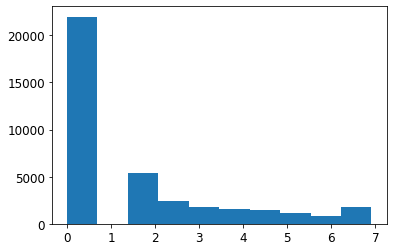

In [296]:
_ = plt.hist(ll_sample)

In [297]:
spearmanr(uncertainties, ll_sample)[0]

-0.17770833105085976

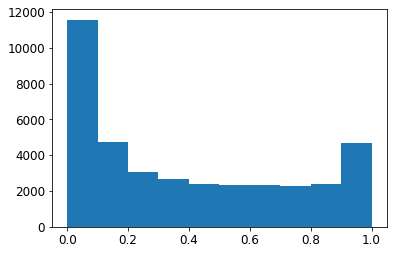

In [299]:
_ = plt.hist(uncertainties)

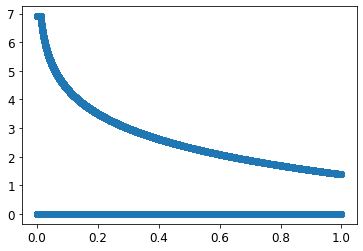

In [298]:
plt.scatter(uncertainties, ll_sample)

In [220]:
np.corrcoef(uncertainties, ll_sample)

array([[ 1.        , -0.18249195],
       [-0.18249195,  1.        ]])

### Brier score

In [221]:
def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

def brier_multi_single(targets, probs):
    return np.sum((probs - targets)**2, axis=1)

In [222]:
lb = LabelBinarizer()
tv_cat = lb.fit_transform(true_values)

In [223]:
brier_instace = brier_multi_single(tv_cat, y_pred_proba)

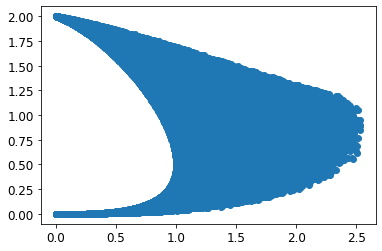

In [224]:
plt.scatter(uncertainties, brier_instace)

In [225]:
spearmanr(uncertainties, brier_instace)[0]

-0.20660522048232655

# Entropy bins

In [148]:
def metric_per_entropy_bin(number_bins, uncertainties, true_values, pred, pred_proba, metric):

    uncertainties = pd.Series(np.hstack(uncertainties))
    entropy_bins = pd.qcut(pd.Series(uncertainties), number_bins, labels=list(range(number_bins)))
    
    metrics_bin = []
    lb = LabelBinarizer()
    true_values_cat = lb.fit_transform(true_values)
    
    for i in range(number_bins):
        sel_index = entropy_bins[entropy_bins == i].index
        sel_true_values_cat = true_values_cat[sel_index, :]
        sel_true_values = true_values[sel_index]
        sel_predictions = pred[sel_index]
        sel_probas = pred_proba[sel_index, :]
        
        if metric == 'accuracy':
            metrics_bin.append(accuracy_score(sel_true_values, sel_predictions))
            
        if metric == 'log_loss':
            metrics_bin.append(log_loss(sel_true_values_cat, sel_probas))
            
        if metric == 'auc':
            metrics_bin.append(roc_auc_score(sel_true_values_cat, sel_probas, average='weighted', multi_class='ovo'))
            
        if metric == 'mcc':
            metrics_bin.append(matthews_corrcoef(sel_true_values, sel_predictions))
            
    return metrics_bin
    

In [149]:
metric_per_entropy_bin(10, uncertainties, true_values, y_pred, y_pred_proba, 'accuracy')

[0.3791734078540962,
 0.39138108545374317,
 0.3722606265627298,
 0.3512281217826151,
 0.3351963524047654,
 0.3112680200058841,
 0.310339755846448,
 0.29622003235769967,
 0.2734225621414914,
 0.23429916164141787]

#### Accuracy

In [338]:
acc_per_decile = {}
number_bins = 10
for data_key in all_results.keys():
    data_raw = all_results[data_key]['raw']['raw']['adwin_uncertainty 0']

    true_values = data_raw['tv']
    y_pred_proba = data_raw['probs']
    uncertainties = data_raw['uncertainties']
    y_pred = data_raw['preds']

    results = metric_per_entropy_bin(number_bins, uncertainties, true_values, y_pred, y_pred_proba, 'accuracy')
    acc_per_decile[data_key] = results

In [341]:
selection = ['Electricity', 'Gas_Sensor', 'Insects_Abrupt', 'Insects_Incremental', 'Insects_Inc_Abr', 
             'Insects_Inc_Reoc', 'Rialto']

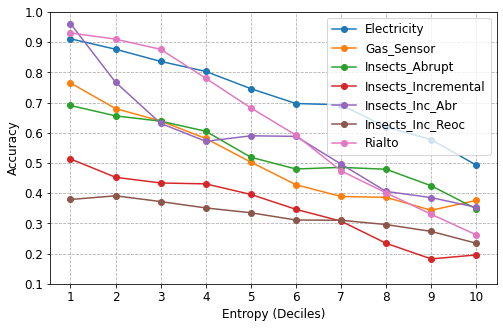

In [342]:
x = np.linspace(1,10,number_bins)
fig, ax1 = plt.subplots(figsize = (8,5))
for key in selection:
    ax1.plot(x, acc_per_decile[key], marker='o', label = key)

ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Entropy (Deciles)')
ax1.set_ylim([0.1,1])
ax1.grid(True, ls = '--')
ax1.legend()
ax1.set_xticks(x)

plt.rcParams.update({'font.size': 12})

fig.savefig("Accuracy_Entropy.pdf", bbox_inches='tight')

plt.show()


#### Log loss

In [343]:
logloss_per_decile = {}
number_bins = 10
for data_key in selection:
    data_raw = all_results[data_key]['raw']['raw']['adwin_uncertainty 0']

    true_values = data_raw['tv']
    y_pred_proba = data_raw['probs']
    uncertainties = data_raw['uncertainties']
    y_pred = data_raw['preds']

    results = metric_per_entropy_bin(number_bins, uncertainties, true_values, y_pred, y_pred_proba, 'log_loss')
    logloss_per_decile[data_key] = results

logloss_per_decile.keys()
selection = ['Electricity', 'Insects_Abrupt', 'Insects_Incremental', 'Insects_Inc_Abr', 'Insects_Inc_Reoc']

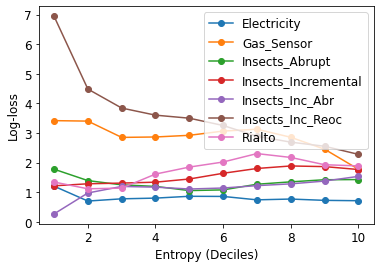

In [344]:
x = np.linspace(1,10,number_bins)
plt.figure()
for key in selection:
    plt.plot(x, logloss_per_decile[key], marker='o', label = key)

plt.ylabel('Log-loss')
plt.xlabel('Entropy (Deciles)')
#plt.ylim([0.1,1])
plt.legend()
plt.show()

# Confidence

In [345]:
data_raw = all_results['Electricity']['raw']['raw']['adwin_uncertainty 0']

true_values = data_raw['tv']
y_pred_proba = data_raw['probs']
uncertainties = data_raw['uncertainties']
y_pred = data_raw['preds']

(array([ 1164.,  1228.,  1333.,  1457.,  1639.,  2055.,  2585.,  3312.,
         4710., 19034.]),
 array([0.5000015 , 0.5500013 , 0.6000012 , 0.65000105, 0.7000009 ,
        0.7500007 , 0.8000006 , 0.85000044, 0.9000003 , 0.95000017,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

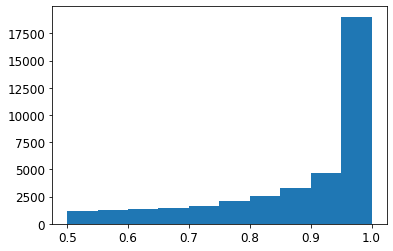

In [346]:
confidence = y_pred_proba.max(axis = 1)
plt.hist(confidence)

In [347]:
def metric_per_confidence(true_values, pred, pred_proba, metric):
    
    confidence = pred_proba.max(axis = 1)
    confidence = pd.Series(confidence)
    metrics_bin = []
    lb = LabelBinarizer()
    true_values_cat = lb.fit_transform(true_values)
    
    for i in np.linspace(0,0.95,20):
        sel_index = confidence[confidence > i].index
        sel_true_values_cat = true_values_cat[sel_index, :]
        sel_true_values = true_values[sel_index]
        sel_predictions = pred[sel_index]
        sel_probas = pred_proba[sel_index, :]
        
        if metric == 'accuracy':
            metrics_bin.append(accuracy_score(sel_true_values, sel_predictions))
            
        if metric == 'log_loss':
            metrics_bin.append(log_loss(sel_true_values_cat, sel_probas))
            
        if metric == 'auc':
            metrics_bin.append(roc_auc_score(sel_true_values_cat, sel_probas, average='weighted', multi_class='ovo'))
            
        if metric == 'mcc':
            metrics_bin.append(matthews_corrcoef(sel_true_values, sel_predictions))

    return metrics_bin

In [348]:
_ = metric_per_confidence(true_values, y_pred, y_pred_proba, 'accuracy')

In [349]:
acc_per_confidence = {}
for data_key in all_results.keys():
    data_raw = all_results[data_key]['raw']['raw']['adwin_uncertainty 0']

    true_values = data_raw['tv']
    y_pred_proba = data_raw['probs']
    uncertainties = data_raw['uncertainties']
    y_pred = data_raw['preds']

    results = metric_per_confidence(true_values, y_pred, y_pred_proba, 'accuracy')
    acc_per_confidence[data_key] = results

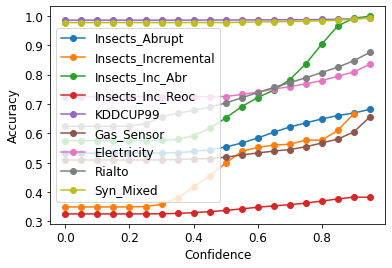

In [350]:
x = np.linspace(0,0.95,20)
plt.figure()
for key in acc_per_confidence.keys():
    plt.plot(x, acc_per_confidence[key], marker='o', label = key)

plt.ylabel('Accuracy')
plt.xlabel('Confidence')
#plt.ylim([0.1,1])
plt.legend()
plt.show()


In [351]:
def metric_per_confidence_bin(number_bins, true_values, pred, pred_proba, metric):    
    
    confidence = pred_proba.max(axis = 1)
    confidence = pd.Series(confidence)
    confidence_bins = pd.qcut(confidence, number_bins, labels=list(range(number_bins)))
    metrics_bin = []
    lb = LabelBinarizer()
    true_values_cat = lb.fit_transform(true_values)
    
    for i in range(number_bins):
        sel_index = confidence_bins[confidence_bins == i].index
        sel_true_values_cat = true_values_cat[sel_index, :]
        sel_true_values = true_values[sel_index]
        sel_predictions = pred[sel_index]
        sel_probas = pred_proba[sel_index, :]
        
        if metric == 'accuracy':
            metrics_bin.append(accuracy_score(sel_true_values, sel_predictions))
            
        if metric == 'log_loss':
            metrics_bin.append(log_loss(sel_true_values_cat, sel_probas))
            
        if metric == 'auc':
            metrics_bin.append(roc_auc_score(sel_true_values_cat, sel_probas, average='weighted', multi_class='ovo'))
            
        if metric == 'mcc':
            metrics_bin.append(matthews_corrcoef(sel_true_values, sel_predictions))

    return metrics_bin

In [352]:
acc_per_confidence = {}
for data_key in selection:
    data_raw = all_results[data_key]['raw']['raw']['adwin_uncertainty 0']

    true_values = data_raw['tv']
    y_pred_proba = data_raw['probs']
    uncertainties = data_raw['uncertainties']
    y_pred = data_raw['preds']

    results = metric_per_confidence_bin(10, true_values, y_pred, y_pred_proba, 'accuracy')
    acc_per_confidence[data_key] = results

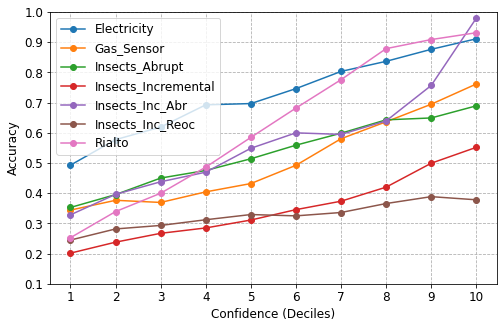

In [353]:
x = np.linspace(1,10,number_bins)
fig, ax1 = plt.subplots(figsize = (8,5))
for key in selection:
    ax1.plot(x, acc_per_confidence[key], marker='o', label = key)

ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Confidence (Deciles)')
ax1.set_ylim([0.1,1])
ax1.grid(True, ls = '--')
ax1.legend()
ax1.set_xticks(x)

plt.rcParams.update({'font.size': 12})

fig.savefig("Accuracy_Confidence.pdf", bbox_inches='tight')

plt.show()

# Plots paper

In [354]:
all_results_reg = {}

key = 'Air_Quality'
local = {}
filename = '../Experiment_AirQuality/results_MCDropout_air.pickle'
local['raw'] = pickle.load(open(filename, 'rb'))
all_results_reg[key] = local

key = 'Bike_Sharing'
local = {}
filename = '../Experiment_BikeSharing/results_MCDropout_bike.pickle'
local['raw'] = pickle.load(open(filename, 'rb'))
all_results_reg[key] = local

In [355]:
for key in all_results_reg.keys():
    all_results_reg[key]['summary'] = print_evaluation(all_results_reg[key]['raw'])

In [356]:
for key in all_results_reg.keys():
    table = all_results_reg[key]['summary']
    table.insert(1, 'RMSE', np.sqrt(table['MSE']))
    all_results_reg[key]['summary'] = table

In [357]:
def metric_per_var_bin(number_bins, uncertainties, true_values, pred, metric):

    uncertainties = pd.Series(np.hstack(uncertainties))
    entropy_bins = pd.qcut(pd.Series(uncertainties), number_bins, labels=list(range(number_bins)))
    
    metrics_bin = []
    
    for i in range(number_bins):

        sel_index = entropy_bins[entropy_bins == i].index
        sel_true_values = true_values[sel_index]
        sel_predictions = pred[sel_index]
        
        if metric == 'rmse':
            metrics_bin.append(np.sqrt(mean_squared_error(sel_true_values, sel_predictions)))
            
        if metric == 'smape':
            metrics_bin.append(smape(sel_true_values, sel_predictions))
            
        if metric == 'mae':
            metrics_bin.append(mean_absolute_error(sel_true_values, sel_predictions))
            
    return metrics_bin

In [360]:
mse_per_decile = {}
number_bins = 10

for data_key in all_results_reg.keys():
    data_raw = all_results_reg[data_key]['raw']['raw']['adwin_uncertainty 0']

    true_values = data_raw['tv']
    y_pred_proba = data_raw['probs']
    uncertainties = data_raw['uncertainties']
    y_pred = data_raw['preds']

    results = metric_per_var_bin(number_bins, uncertainties, true_values, y_pred, 'rmse')
    #print('pred: ', data_key,true_values)
    mse_per_decile[data_key] = results

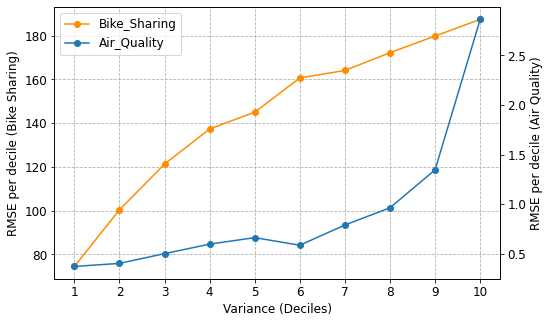

In [362]:
x = np.linspace(1,10,number_bins)

#fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (16,5))

fig, ax1 = plt.subplots(figsize = (8,5))
key = 'Bike_Sharing'
ax1.set_ylabel('RMSE per decile (Bike Sharing)')
lns1 = ax1.plot(x, mse_per_decile[key], marker='o', label = key, color = 'darkorange')

ax2 = ax1.twinx()

key = 'Air_Quality'
ax2.set_ylabel('RMSE per decile (Air Quality)')
lns2 = ax2.plot(x, mse_per_decile[key], marker='o', label = key)

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.set_xlabel('Variance (Deciles)')
ax1.set_xticks(x)
ax1.grid(True, ls = '--')
#plt.ylim([0.1,1])

plt.rcParams.update({'font.size': 12})

fig.savefig("RMSE_Variance.pdf", bbox_inches='tight')

plt.show()

In [380]:
all_results['KDDCUP99']['raw'].keys()

dict_keys(['metrics', 'errors', 'drifts', 'raw'])

In [384]:
all_results['KDDCUP99']['raw']['raw']['adwin_uncertainty 0'].keys()

dict_keys(['uncertainties', 'tv', 'tv_cat', 'preds', 'probs', 'errors'])